<a href="https://colab.research.google.com/github/sranifp/PBA-Sentimen-Analisis-UBER/blob/main/TFIDF_UBER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

# Perintah untuk mengaitkan Google Drive Anda
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

file_path_di_drive = '/content/drive/MyDrive/Pengolahan Bahasa Alami/Bu IRMA/Tugas Individu/Data/uber_reviews_clean.csv'

In [3]:
# Load the dataset
df_clean = pd.read_csv(file_path_di_drive)
display(df_clean.head())

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,content_no_punct,content_no_emoji,content_tokens,content_final_clean
0,501420d1-a032-4981-bd64-fb948333bd2f,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,doliczają dodatkowe opłaty ~10% po zakończonej...,1,0,4.601.10001,2025-10-28 09:51:39,NaN,NaN,4.601.10001,doliczają dodatkowe opłaty 10 po zakończonej u...,doliczają dodatkowe opłaty 10 po zakończonej u...,"['doliczają', 'dodatkowe', 'opłaty', '10', 'po...",doliczają dodatkowe opłaty 10 po zakończonej u...
1,5dc1a519-a151-4c46-88df-7aae80f24a3d,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,excellent service,5,0,4.601.10001,2025-10-28 09:48:31,NaN,NaN,4.601.10001,excellent service,excellent service,"['excellent', 'service']",excellent
2,2fa137d8-0442-4b81-8ae4-3c2d1bf5120a,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,ابلكيشن تحفة و كل الكباتن بتاعتة محترمين,5,0,4.601.10001,2025-10-28 09:46:39,NaN,NaN,4.601.10001,ابلكيشن تحفة و كل الكباتن بتاعتة محترمين,ابلكيشن تحفة و كل الكباتن بتاعتة محترمين,"['ابلكيشن', 'تحفة', 'و', 'كل', 'الكباتن', 'بتا...",ابلكيشن تحفة و كل الكباتن بتاعتة محترمين
3,ce296caf-168a-4876-8ea3-7907673d20ad,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,cool,5,0,NaN,2025-10-28 09:36:33,NaN,NaN,NaN,cool,cool,['cool'],cool
4,7ec3b59a-2129-4ee7-b7ae-a5ef7acdcbe0,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,"app says 1 min waiting, turned out waiting for...",1,0,4.601.10001,2025-10-28 09:30:28,NaN,NaN,4.601.10001,app says 1 min waiting turned out waiting for ...,app says 1 min waiting turned out waiting for ...,"['app', 'says', '1', 'min', 'waiting', 'turned...",say 1 waiting turned waiting 10 waiting fee ta...


# **TFIDF**

**Persiapan Data dan Pembagian Set (X dan y)**

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split

# --- A. Pembuatan Label Sentimen Biner ---
# Klasifikasi:
# Skor 4 & 5 -> Positif (1)
# Skor 1 & 2 -> Negatif (0)
# Skor 3 (Netral) -> Diabaikan (-1)
df_clean['sentiment'] = df_clean['score'].apply(lambda x: 1 if x > 3 else (0 if x < 3 else -1))

# Filter DataFrame hanya untuk sentimen Positif dan Negatif
df_model = df_clean[df_clean['sentiment'] != -1].copy()

# Tentukan variabel X (fitur teks bersih) dan y (label sentimen)
X = df_model['content_final_clean'].astype(str)
y = df_model['sentiment']

# --- B. Pembagian Data (Train & Test Split) ---
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,            # 20% untuk data uji
    random_state=42,          # Agar hasil pembagian data selalu sama
    stratify=y                # Memastikan proporsi sentimen di data latih dan uji sama
)

print("✅ Label Sentimen Biner Dibuat dan Data Dibagi.")
print(f"Total data yang digunakan: {X.shape[0]} baris.")
print(f"Data Latih (X_train): {X_train.shape[0]} baris.")
print(f"Data Uji (X_test): {X_test.shape[0]} baris.")

✅ Label Sentimen Biner Dibuat dan Data Dibagi.
Total data yang digunakan: 1296957 baris.
Data Latih (X_train): 1037565 baris.
Data Uji (X_test): 259392 baris.


**Implementasi TF-IDF Vectorizer (Feature Extraction)**

In [5]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# --- Inisialisasi TfidfVectorizer ---
tfidf_vectorizer = TfidfVectorizer(
    max_features=1000,        # Batasi kosakata hingga 1000 kata teratas
    min_df=5,                 # Abaikan kata yang muncul di < 5 ulasan (filter typo/noise)
    max_df=0.8,               # Abaikan kata yang muncul di > 80% ulasan (filter stopword kuat)
    ngram_range=(1, 2)        # Menggunakan unigram (kata tunggal) dan bigram (pasangan kata)
)

# --- Penerapan TF-IDF ---
# 1. Terapkan FIT & TRANSFORM pada data latih
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# 2. Terapkan TRANSFORM SAJA pada data uji (Menggunakan Vocabulary yang dipelajari dari data latih)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print("✅ Proses TF-IDF Selesai.")
print(f"Bentuk Matriks TF-IDF Data Latih: {X_train_tfidf.shape}")
print(f"Bentuk Matriks TF-IDF Data Uji: {X_test_tfidf.shape}")

✅ Proses TF-IDF Selesai.
Bentuk Matriks TF-IDF Data Latih: (1037565, 1000)
Bentuk Matriks TF-IDF Data Uji: (259392, 1000)


**Menampilkan Fitur (Vocabulary) TF-IDF**

In [6]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# ASUMSI: tfidf_vectorizer sudah terdefinisi dari blok kode sebelumnya.

# Ambil nama-nama fitur (kata/bigram) yang digunakan sebagai kolom
feature_names = tfidf_vectorizer.get_feature_names_out()

print("\n--- Contoh Fitur (Vocabulary) TF-IDF ---")
# Menampilkan 50 fitur pertama
print(list(feature_names[:50]))

# Menampilkan Bobot TF-IDF dari 5 Baris Pertama Data Uji
df_tfidf_test_sample = pd.DataFrame(
    X_test_tfidf[:5].toarray(),
    columns=feature_names
)

# Menampilkan 10 kolom pertama dari sampel data uji
print("\n--- Contoh Bobot TF-IDF pada Data Uji (5 baris, 10 fitur) ---")
print(df_tfidf_test_sample.iloc[:5, :10])


--- Contoh Fitur (Vocabulary) TF-IDF ---
['10', '100', '12', '15', '1st', '20', '200', '25', '30', '3rd', '40', '45', '50', '500', '60', 'able', 'absolute', 'absolutely', 'ac', 'accept', 'accepted', 'accepting', 'accepts', 'access', 'account', 'account disabled', 'accurate', 'action', 'actual', 'actually', 'ad', 'add', 'added', 'adding', 'additional', 'address', 'advance', 'affordable', 'ago', 'airport', 'al', 'allow', 'allowed', 'allowing', 'almost', 'alot', 'already', 'alternative', 'although', 'amazing']

--- Contoh Bobot TF-IDF pada Data Uji (5 baris, 10 fitur) ---
    10  100   12   15  1st   20  200   25        30  3rd
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.291141  0.0
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0


**Klasifikasi Sentimen & Perbandingan Model**

✅ Data Split dan TF-IDF Transformation Selesai.

--- Akurasi Model ---
1. Logistic Regression Akurasi: 0.8887
2. Naive Bayes Akurasi: 0.8752
3. Linear SVC Akurasi: 0.8880

--- Laporan Klasifikasi (Linear SVC - Model Terbaik) ---
              precision    recall  f1-score   support

 Negatif (0)       0.87      0.84      0.86     99420
 Positif (1)       0.90      0.92      0.91    150401

    accuracy                           0.89    249821
   macro avg       0.89      0.88      0.88    249821
weighted avg       0.89      0.89      0.89    249821


--- DataFrame Perbandingan Akurasi ---
                 Model   Akurasi
0  Logistic Regression  0.888712
2           Linear SVC  0.887992
1          Naive Bayes  0.875211


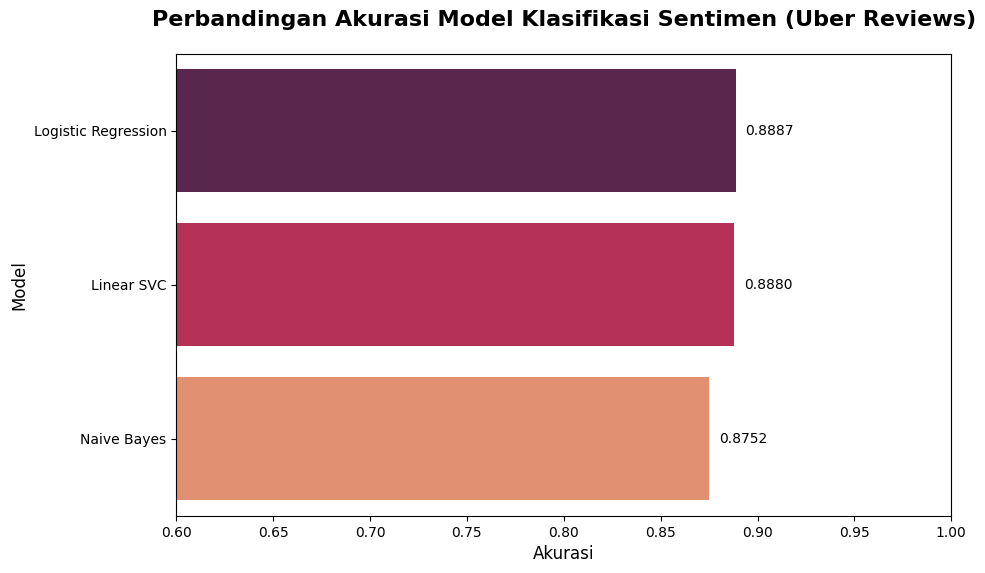

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

# --- 1. SETUP DATA (MEMASTIKAN df_clean TERSEDIA) ---
# Jika Anda sudah menjalankan mount drive dan load file di sel terpisah,
# Anda dapat menghapus atau mengomentari bagian ini.
# Saya sertakan di sini untuk memastikan kode berjalan secara mandiri jika diperlukan.
file_path_di_drive = '/content/drive/MyDrive/Pengolahan Bahasa Alami/Bu IRMA/Tugas Individu/Data/uber_reviews_clean.csv'

try:
    df_clean = pd.read_csv(file_path_di_drive)
    df_clean['score'] = pd.to_numeric(df_clean['score'], errors='coerce').astype('Int64')
    df_clean.dropna(subset=['content_final_clean', 'score'], inplace=True)
except FileNotFoundError:
    print(f"❌ ERROR: File tidak ditemukan di jalur: {file_path_di_drive}")
    exit()

# Membuat Label Sentimen Biner
# Skor 4 & 5 -> Positif (1); Skor 1 & 2 -> Negatif (0); Skor 3 -> Netral (-1)
df_clean['sentiment'] = df_clean['score'].apply(lambda x: 1 if x > 3 else (0 if x < 3 else -1))
df_model = df_clean[df_clean['sentiment'] != -1].copy()

# Tentukan X (fitur) dan y (target)
X = df_model['content_final_clean'].astype(str)
y = df_model['sentiment']

# Pembagian Data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- 2. TF-IDF TRANSFORMATION ---
tfidf_vectorizer = TfidfVectorizer(max_features=1000, min_df=5, max_df=0.8, ngram_range=(1, 2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print("✅ Data Split dan TF-IDF Transformation Selesai.")


# --- 3. PELATIHAN & EVALUASI MODEL ---
model_results = []

# Model 1: Logistic Regression
log_reg = LogisticRegression(random_state=42, max_iter=2000)
log_reg.fit(X_train_tfidf, y_train)
y_pred_log_reg = log_reg.predict(X_test_tfidf)
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
model_results.append({'Model': 'Logistic Regression', 'Akurasi': accuracy_log_reg})

# Model 2: Multinomial Naive Bayes
naive_bayes = MultinomialNB()
naive_bayes.fit(X_train_tfidf, y_train)
y_pred_nb = naive_bayes.predict(X_test_tfidf)
accuracy_nb = accuracy_score(y_test, y_pred_nb)
model_results.append({'Model': 'Naive Bayes', 'Akurasi': accuracy_nb})

# Model 3: Linear SVC (Model terbaik untuk klasifikasi teks)
linear_svc = LinearSVC(random_state=42, max_iter=10000)
linear_svc.fit(X_train_tfidf, y_train)
y_pred_svc = linear_svc.predict(X_test_tfidf)
accuracy_svc = accuracy_score(y_test, y_pred_svc)
model_results.append({'Model': 'Linear SVC', 'Akurasi': accuracy_svc})

print(f"\n--- Akurasi Model ---")
print(f"1. Logistic Regression Akurasi: {accuracy_log_reg:.4f}")
print(f"2. Naive Bayes Akurasi: {accuracy_nb:.4f}")
print(f"3. Linear SVC Akurasi: {accuracy_svc:.4f}")


print("\n--- Laporan Klasifikasi (Linear SVC - Model Terbaik) ---")
print(classification_report(y_test, y_pred_svc, target_names=['Negatif (0)', 'Positif (1)']))


# --- 4. PERBANDINGAN DAN VISUALISASI ---
df_comparison = pd.DataFrame(model_results).sort_values(by='Akurasi', ascending=False)

print("\n--- DataFrame Perbandingan Akurasi ---")
print(df_comparison)

plt.figure(figsize=(10, 6))
# Plot Bar Perbandingan
sns.barplot(data=df_comparison, x='Akurasi', y='Model', palette='rocket', hue='Model', legend=False, dodge=False)
plt.title('Perbandingan Akurasi Model Klasifikasi Sentimen (Uber Reviews)', fontsize=16, weight='bold', pad=20)
plt.xlabel('Akurasi', fontsize=12)
plt.ylabel('Model', fontsize=12)
plt.xlim(0.6, 1.0)

# Menambahkan label pada bar
for index, value in enumerate(df_comparison['Akurasi']):
    plt.text(value + 0.005, index, f'{value:.4f}', va='center')

plt.show()